## Classification of Handwritten Digits

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.linalg import svd, norm
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from operator import itemgetter
from heapq import nsmallest

## Data

In [2]:
xls = pd.ExcelFile('data.xlsx')
x_train = np.asarray(pd.read_excel(xls, 'azip', header=None))
y_train = pd.read_excel(xls, 'dzip', header=None)
x_test = np.asarray(pd.read_excel(xls, 'testzip', header=None))
y_test = pd.read_excel(xls, 'dtest', header=None)

In [3]:
x_train.shape, x_test.shape

((256, 1707), (256, 2007))

Function for displaying images

In [4]:
def v2im(vec, label):
    title = "Label of image is:"+str(label)
    a = vec.reshape(16, 16)
    a = (a - min(a.ravel())) * np.ones(a.shape)
    a = (20 / max(a.ravel())) * a
    plt.imshow(a, cmap="gray")
    plt.title(title)
    plt.show()
    return

Scale Data

In [5]:
normalizer = MinMaxScaler(feature_range=(-1.0, 1.0))
x_train = pd.DataFrame(normalizer.fit_transform(x_train.T).T)
x_test = pd.DataFrame(normalizer.transform(x_test.T).T)

Display an example image

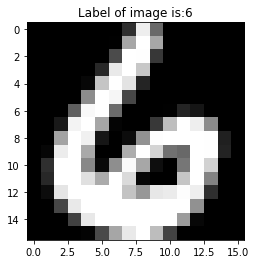

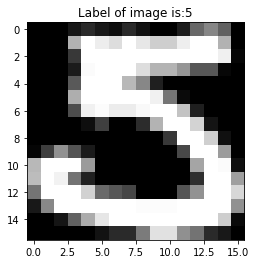

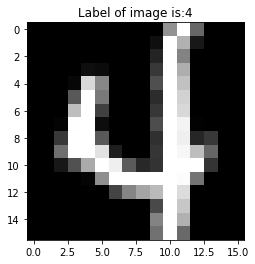

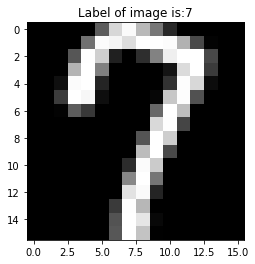

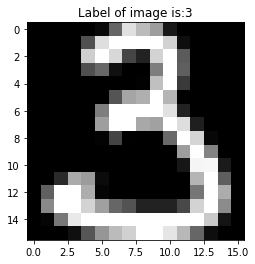

In [6]:
for i in range(0,5):
    v2im(x_train[i].to_numpy(), y_train[i][0])

## SVD for each class

SVD is applied to 10 matrices (1 per class), each matrix containing the vectors that represent images belonging to a particular class. After decomposition, each one is represented by three matrices: u, s, v. This concludes the training phase of the algorithm.

In [7]:
#create arrays containing the column indexes for each class/number
y_train_transpose = y_train.T
indexes = [y_train_transpose[y_train_transpose[0]==i].index for i in range(0,10)]

In [8]:
#u matrices - singular vectors for each class
U = []
S = []
V = []
for i in range(0,10):
    u,s,v = svd(x_train[indexes[i]], full_matrices=True)
    U.append(u)
    S.append(s)
    V.append(v)

Plot some vectors of SVD resulting matrix u. The first singular vector as expected looks like a 3. The following singular images represent the dominating variations of the training set around the first singular image.

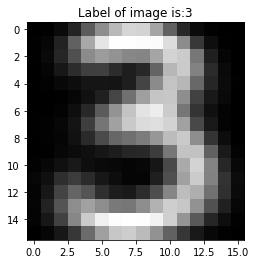

In [9]:
v2im((U[3][:,0]),3)

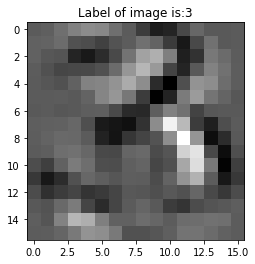

In [10]:
v2im((U[3][:,10]),3)

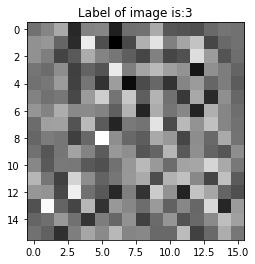

In [11]:
v2im((U[3][:,100]),3)

## Classification

Classification is performed according to relative residual in least squares problem, calculated by the formula: $\frac{|(I - U_k {U_k}^T)z|_2}{|z|_2}$

In [12]:
accuracy = []
best_acc = 0.0
best_pred = []
best_n = 0
N = np.arange(5, 21).tolist()
for n in N:
    predict = []
    for j in range(x_test.shape[1]):
        residual = []
        for i in range(0,10):
            u = U[i][:,:n]
            uT = u.T
            I = np.eye(256,256)
            z = x_test[j]
            residual.append(norm(np.dot(I-np.dot(u,uT), z))/norm(z))
        index, element = min(enumerate(residual), key=itemgetter(1))
        predict.append(index)
    acc=accuracy_score(y_test.to_numpy().T, predict)
    accuracy.append(acc)
    if best_acc<acc:
        best_acc=acc
        best_pred=predict
        best_n=n

Accuracy vs the number of basis vectors:

In [13]:
for i,n in enumerate(N):
    print("Algorithm accuracy for n = ", n, " is ", round(accuracy[i]*100, 2), "%")
print("\nBest accuracy is: ", round(best_acc*100, 2), "% for n = ", best_n)

Algorithm accuracy for n =  5  is  90.23 %
Algorithm accuracy for n =  6  is  90.53 %
Algorithm accuracy for n =  7  is  91.68 %
Algorithm accuracy for n =  8  is  92.03 %
Algorithm accuracy for n =  9  is  92.73 %
Algorithm accuracy for n =  10  is  93.17 %
Algorithm accuracy for n =  11  is  93.17 %
Algorithm accuracy for n =  12  is  93.67 %
Algorithm accuracy for n =  13  is  93.62 %
Algorithm accuracy for n =  14  is  93.87 %
Algorithm accuracy for n =  15  is  94.12 %
Algorithm accuracy for n =  16  is  93.87 %
Algorithm accuracy for n =  17  is  93.82 %
Algorithm accuracy for n =  18  is  94.22 %
Algorithm accuracy for n =  19  is  94.07 %
Algorithm accuracy for n =  20  is  93.97 %

Best accuracy is:  94.22 % for n =  18


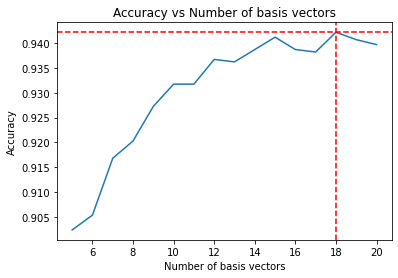

In [14]:
plt.plot(N,accuracy)
plt.axvline(x=best_n, color='r', linestyle='--')
plt.axhline(y=best_acc, color='r', linestyle='--')
plt.title("Accuracy vs Number of basis vectors")
plt.xlabel("Number of basis vectors")
plt.ylabel("Accuracy")
plt.show()

## Metrics and Confusion Matrix

As it can be observed the algorithm performs best when 18 singular vectors are used. Below are presented some metrics to gain an insight on algorithm performance (when 18 singular vectors are used). Observe that classes 3 and 5 have the lowest scores, making them the hardest to classify and that class 1 has the highest, indicating that this is the easiest to classify.

In [15]:
print(classification_report(y_test.T, best_pred, digits=4))
print(confusion_matrix(y_test.T, best_pred))

              precision    recall  f1-score   support

           0     0.9392    0.9889    0.9634       359
           1     0.9737    0.9811    0.9774       264
           2     0.9570    0.8990    0.9271       198
           3     0.9146    0.9036    0.9091       166
           4     0.9069    0.9250    0.9158       200
           5     0.9338    0.8812    0.9068       160
           6     0.9879    0.9588    0.9731       170
           7     0.9527    0.9592    0.9559       147
           8     0.9387    0.9217    0.9301       166
           9     0.9121    0.9379    0.9248       177

    accuracy                         0.9422      2007
   macro avg     0.9416    0.9356    0.9383      2007
weighted avg     0.9425    0.9422    0.9420      2007

[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 178   2   5   0   0   1   3   0]
 [  2   0   3 150   1   6   0   1   2   1]
 [  2   1   0   0 185   2   0   3   0   7]
 [  7   1   1   5   0 141 

For those images that were misclassified there are 5 chosen in random and plotted. Most of them are badly written and indeed, the decision of the classifier is not far from what it was drawn, even though the intended digit was different.

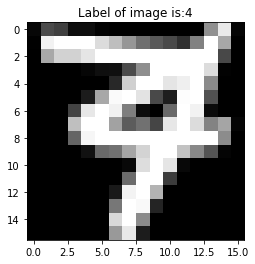

Classification predicted:  7


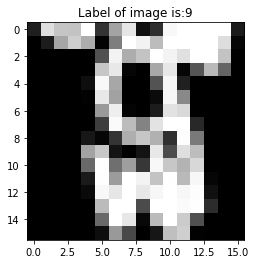

Classification predicted:  3


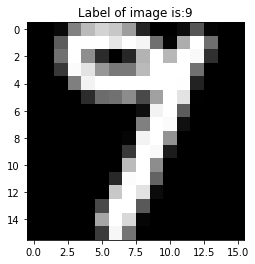

Classification predicted:  7


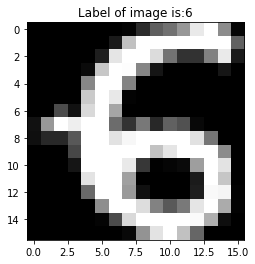

Classification predicted:  5


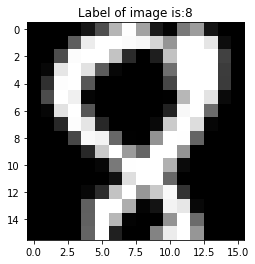

Classification predicted:  9


In [16]:
#list of misclassified images
misclass = y_test.T!=np.array(best_pred).reshape(2007,1)
#random choise
random.seed(2)
rand = random.choices(misclass[misclass[0]==True].index.tolist(), k=5)
#plot the randomly chosen
for i in range(len(rand)):
    v2im(x_test[rand[i]].to_numpy(), y_test[rand[i]][0])
    print("Classification predicted: ", predict[rand[i]])

## Singular values of classes

Since the first singular value of class 1 is significantly larger than the ones of other classes, we should be able to use less basis vectors for ths class, without it affecting the algorithm's accuracy. Class 1 has, also, the best scores as stated before.

In [17]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
for n in range(0,10):
    print("n = ", n, " ", S[n][:5])

n =  0   [ 184.392  97.630  62.051  54.167  41.073]
n =  1   [ 234.041  41.931  24.849  16.295  13.611]
n =  2   [ 138.113  57.422  46.413  40.992  37.529]
n =  3   [ 126.619  39.773  33.325  29.874  27.965]
n =  4   [ 123.003  41.625  34.932  32.292  26.815]
n =  5   [ 94.210  37.856  35.797  28.025  24.051]
n =  6   [ 141.954  52.195  37.966  32.015  26.287]
n =  7   [ 160.108  46.732  36.536  34.696  31.515]
n =  8   [ 133.054  41.644  34.463  30.499  28.716]
n =  9   [ 141.218  45.723  30.057  29.457  22.932]


In [18]:
for k,n in enumerate([0,1,2,5]):
    predict = []
    for j in range(x_test.shape[1]):
        residual = []
        for i in range(0,10):
            if i==1:
                u = U[i][:,:n]
                uT = u.T
                I = np.eye(256,256)
                z = x_test[j]
            else:
                u = U[i][:,:18]
                uT = u.T
                I = np.eye(256,256)
                z = x_test[j]
            residual.append(norm(np.dot(I-np.dot(u,uT), z))/norm(z))
        index, element = min(enumerate(residual), key=itemgetter(1))
        predict.append(index)
    print("\nExperiment: ", k+1, " \nBasis vectors: ", n, "\nAccuracy: ", np.round(accuracy_score(y_test.to_numpy().T, predict)*100, 2), "%")


Experiment:  1  
Basis vectors:  0 
Accuracy:  81.56 %

Experiment:  2  
Basis vectors:  1 
Accuracy:  92.18 %

Experiment:  3  
Basis vectors:  2 
Accuracy:  93.27 %

Experiment:  4  
Basis vectors:  5 
Accuracy:  93.72 %


Despite using such a small amount of basis vectors for class 1 the accuracy of the model is not affected that much.

## Two-stage algorithm with SVD

Calculate differences in percentage (smallest to other residuals).
Classify if differences are above 20%. To check that, find the smallest residual and calculate its differences, as percent, with the other residuals. Get the second smallest percentage (since the smallest will always be 0 coming from claclulation smallest_res-smallest_res/smallest_res) and if it is greater than 20% classify the image to the class with smallest residual. Otherwise run again with 18 basis vectors as previously.

In [22]:
threshold = [0.1,0.2,0.3,0.4,0.5]
for t in threshold:
    predict = []
    count_stage2 = 0
    for j in range(x_test.shape[1]):
        #stage 1
        residual = []
        for i in range(0,10):
            u = U[i][:,:1]
            uT = u.T
            I = np.eye(256,256)
            z = x_test[j]
            residual.append(norm(np.dot(I-np.dot(u,uT), z))/norm(z))
        index, element = min(enumerate(residual), key=itemgetter(1))
        differences = [(residual[i]-element)/element for i in range(0,10)]
        if nsmallest(2, differences)[-1]>t:
            predict.append(index)
        else:
            #stage 2
            residual = []
            count_stage2+=1
            for i in range(0,10):
                u = U[i][:,:18]
                uT = u.T
                I = np.eye(256,256)
                z = x_test[j]
                residual.append(norm(np.dot(I-np.dot(u,uT), z))/norm(z))
                index, element = min(enumerate(residual), key=itemgetter(1))
            predict.append(index)

    print("Threshold: ", t, " Accuracy: ", np.round(accuracy_score(y_test.to_numpy().T, predict)*100, 2), "%")
    print("Stage 2 was unnecessary: ", np.round(((x_test.shape[1]-count_stage2)/x_test.shape[1])*100, 2), "% of times")

Threshold:  0.1  Accuracy:  92.73 %
Stage 2 was unnecessary:  63.13 % of times
Threshold:  0.2  Accuracy:  94.02 %
Stage 2 was unnecessary:  42.95 % of times
Threshold:  0.3  Accuracy:  94.22 %
Stage 2 was unnecessary:  30.44 % of times
Threshold:  0.4  Accuracy:  94.22 %
Stage 2 was unnecessary:  22.32 % of times
Threshold:  0.5  Accuracy:  94.22 %
Stage 2 was unnecessary:  16.79 % of times


While accuracy dropped only from 94.22% to 94.02%, Stage 2 was unnecessary 42.95% of the times, implying that algorithm can get a lot faster and consume less memory without sacrifising its performance.

## Tangent Distance